In [52]:
from collections import deque
import heapq
import random
import numpy as np
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Fs

In [53]:
MEMORY_SIZE = 500
MAX_STEP = 60

In [ ]:
class Area():
    

In [54]:
class BikeNet():
    def __init__(self, N, A, R, Q, repair, warmup_time, run_time, start_position=0):
        self.N = N
        self.A = A
        self.R = R
        self.Q = Q
        self.repair = repair
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        self.car = start_position
        self.edge = int(self.A**0.5)
        self.areas = list(range(A + 1))

        self.reset()

    def reset(self):
        self.T = 0
        self.carrier_position = self.car
        self.state = [int(self.N / self.A)] * self.A + [0] * self.A
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            heapq.heappush(self.scheduler, [random.expovariate(self.R[i][0]), -1, i])
        heapq.heapify(self.scheduler)
        return np.array(self.state)

    def warmup(self):
        s = self.reset()

        while self.T < self.warmup_time:
            action = random.randint(0,3)
            result = self.step(action, 0)

        self.T = self.warmup_time
        return np.array(env.state)

    def get_distance(self, start, end):
        dist = abs(start % (self.edge) - end % (self.edge)) + abs(
            start // (self.edge) - end // (self.edge))
        return dist
    
    def step(self, action, not_warm):
        
        cus = 0
        # time for carrier to take the action and repair one bicycle
        dist = self.get_distance(self.carrier_position, action)
        t = dist * 2
        if self.state[action + self.A] > 0:
            t_cursor = self.T + t + self.repair
        else:
            t_cursor = self.T + t

        event = self.scheduler[0]
        self.T, kind, location = event[0], event[1], event[2]

        # update the atate of QN during the tansformation time
        while self.T < t_cursor:
            # 车到达
            if kind == 1:
                self.state[location] += 1
                heapq.heappop(self.scheduler)
            else:# 顾客到达
                if self.state[location] == 0:  # 但没车
                    cus += 1
                    #rewards -= 1
                    heapq.heappop(self.scheduler)
                else:
                    target = np.random.choice(self.areas, 1, p=self.Q[location])[0]
                    if target == self.A:  # 顾客到达，发现是坏车
                        self.state[location] -= 1
                        self.state[location + self.A] += 1
                        continue
                    else:  # 顾客到达，顺利骑行
                        cus += 1
                        self.state[location] -= 1
                        heapq.heappop(self.scheduler)
                        next_time = random.expovariate(self.R[location][1]) + self.T
                        heapq.heappush(self.scheduler, [next_time, 1, target])
                next_time = random.expovariate(self.R[location][0]*0.999**self.T) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, location])

            if self.scheduler:
                event = self.scheduler[0]
                self.T, kind, location = event[0], event[1], event[2]
            else:
                break

        if not_warm == 1:
            if self.state[action + self.A] > 0:
                self.state[self.carrier_position] += 1
                self.state[self.carrier_position + self.A] -= 1

        self.carrier_position = action
        self.T = t_cursor

        s_ = np.array(self.state)

        #if self.T <= self.time_limit and self.scheduler:
        return s_, cus, 0
        #else:
        #    return s_, cus, 1, t
  

In [55]:
      
random.seed(0)
N = 360  # total number of bikes in the QN
A = 9  # A for areas, indicates the number of areas and the action space
R = {}  # [customer_arrval, ride]
for i in range(A): R[i] = [0.25 * i+0.5, 0.2]
#Q = [[0.15,0.3,0.3,0.15,0.1],
#     [0.3,0.15,0.15,0.3,0.1],
#     [0.3,0.15,0.15,0.3,0.1],
#     [0.15,0.3,0.3,0.15,0.1]]
Q = [x/sum(x) for x in np.random.rand(A,A+1)]
# Q = [[0,0.9,0.1], [0.9,0,0.1]]
t_repair = 2
warmup_time = 60
run_time = 180

env = BikeNet(N=N,
              A=A,
              R=R,
              Q=Q,
              repair=t_repair,
              warmup_time=warmup_time,
              run_time=run_time,
              start_position=0)
env.warmup()

array([66, 51, 64, 23, 34,  1,  0,  0,  1,  2, 10,  1,  0,  2, 20,  9,  8,
       18])

In [56]:
class Memory():
    def __init__(self,memsize):
        self.memsize = memsize
        self.memory = deque(maxlen=self.memsize)
    
    def add_episode(self,epsiode):
        self.memory.append(epsiode)
    
    def get_batch(self,bsize):
        sampled_epsiodes = np.array(random.sample(self.memory,bsize))
        #batch = []
        #for episode in sampled_epsiodes:
        #    point = np.random.randint(0,len(episode)+1-time_step)
        #    batch.append(episode[point:point+time_step])
        return sampled_epsiodes

In [57]:
mem = Memory(memsize=MEMORY_SIZE)
# Fill memory
for i in tqdm(range(0,MEMORY_SIZE)):
    
    prev_state = env.warmup()
    processed_prev_state = prev_state
    #processed_prev_state = preprocess_image(prev_state)
    
    action = np.random.randint(0,4)
    #if not env.scheduler: break
    next_state,reward,done = env.step(action,1)
    #time_count += t
    processed_next_state = next_state #preprocess_image(next_state)

    mem.add_episode(list(processed_prev_state)+[action]+[reward]+list(processed_next_state))

    prev_state = next_state
    processed_prev_state = processed_next_state
            
print('Populated with %d Episodes'%(len(mem.memory)))

100%|████████████████████████████████████████| 500/500 [00:25<00:00, 19.25it/s]


Populated with 500 Episodes


In [58]:
"""
This part of code is the Deep Q Network (DQN) brain.
view the tensorboard picture about this DQN structure on: https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/4-3-DQN3/#modification
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
PyTorch
"""
# np.random.seed(1)
# USE_CUDA = torch.cuda.is_available()


# Deep Q Network off-policy
class DQN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DQN, self).__init__()
        self.line1 = nn.Linear(num_inputs, 64)
        self.line2 = nn.Linear(64, 32)
        self.line3 = nn.Linear(32, num_outputs)

    def forward(self, x):
        x = torch.sigmoid(self.line1(x))
        x = F.relu(self.line2(x))
        x = self.line3(x)
        return x

In [59]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
#from NeuralNetwork import DQN

class Train():
    def __init__(
            self,
            n_actions,
            n_features,
            n_episodes,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.n_episodes = n_episodes
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_min = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0.99 if e_greedy_increment is not None else self.epsilon_min

        # total learning step
        self.learn_step_counter = 0

        # consist of [target_net, evaluate_net]
        self.target_net = DQN(n_features, n_actions)
        self.eval_net = DQN(n_features, n_actions)
        self.target_net.load_state_dict(self.eval_net.state_dict())
        #self.eval_net.load_state_dict(torch.load('C:/Rebalancing/data/result/pytorchmodel/params_lossMinusMean.pkl'))

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adagrad(self.eval_net.parameters(), lr=self.lr)


    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.eval_net(Variable(torch.from_numpy(observation).float())).cpu().detach().numpy()
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            # self.sess.run(self.target_replace_op)
            self.target_net.load_state_dict(self.eval_net.state_dict())
            # print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        batch_memory = mem.get_batch(self.batch_size)
        

        self.s = Variable(torch.from_numpy(batch_memory[:, :self.n_features]).float(), requires_grad=True)
        self.a = Variable(torch.from_numpy(batch_memory[:, self.n_features]).long())
        self.r = Variable(torch.from_numpy(batch_memory[:, self.n_features + 1]).float())
        self.s_ = Variable(torch.from_numpy(batch_memory[:, -self.n_features:]).float())

        current_Q_values = self.eval_net(self.s).gather(1, self.a.unsqueeze(1)).view(-1)
        next_Q_values = self.target_net(self.s_).detach().max(1)[0]
        # Compute the target of the current Q values
        target_Q_values = self.r + (self.gamma * next_Q_values)
        # Compute Bellman error
        loss = self.criterion(target_Q_values, current_Q_values)

        self.optimizer.zero_grad()
        # run backward pass
        loss.backward()

        # Perfom the update
        self.optimizer.step()

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon > self.epsilon_min else self.epsilon_min
        self.learn_step_counter += 1



#from bikeNet import BikeNet
#from model import Train
#from SimulationOptimization import BikeNet, Area, binaryInsert
import numpy as np
import random
from tqdm import tqdm
MAX_STEP = 60
#@profile
def run():
    result = []
    for episode in tqdm(range(RL.n_episodes)):
        sum_r = 0
        #sum_c = 0
        step = 0
        step_count = 0
        # initial observation
        observation = env.warmup()

        while step_count<MAX_STEP:

            # RL choose action based on observation
            action = RL.choose_action(observation)
            # action = (action+1)%9
            # RL take action and get next observation and reward
            observation_, reward, done = env.step(action, 1)
            mem.add_episode(list(observation)+[action]+[reward]+list(observation_))

            if step % 10 == 0:
                RL.learn()

            # swap observation
            observation = observation_

            # break while loop when end of this episode
            if done:
                break
            step += 1
            step_count += 1
            sum_r += reward
            #sum_c += n_customer

        result.append(sum_r)

    # end of game
    print('learning over')
    return result

if __name__ == '__main__':
    
    RL = Train(n_actions=A,
               n_features=2 * A,
               n_episodes=1000,
               learning_rate=0.001,
               reward_decay=1.0,
               e_greedy=0.1,
               replace_target_iter=200,
               memory_size=20000,
               e_greedy_increment=-0.0001
               # output_graph=True
               )
    output = run()

    #print(output)
    # RL.plot_cost()

100%|██████████████████████████████████████| 1000/1000 [02:48<00:00,  5.11it/s]


learning over


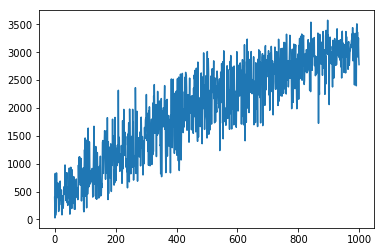

In [60]:
output = np.array(output)
import matplotlib.pyplot as plt
plt.plot(output)

In [25]:
output[-1500:].mean()

759.2806666666667

In [27]:
import pandas as pd
result = pd.DataFrame(output)
result.to_csv('C:/Rebalancing/data/result/pytorchmodel/correctDQN4000.csv')

In [26]:
torch.save(RL.eval_net.state_dict(), 'C:/Rebalancing/data/result/pytorchmodel/params_lossMinusMean.pkl')